# Credit Risk Assessment

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Credit Risk Analysis

/content/drive/MyDrive/Credit Risk Analysis


In [ ]:
!pip install pingouin
!pip install pydeck
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=87aca05a9083c50b408bbe74fa823c6d365e82a4e19ef1ff3e45e27897720645
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import pydeck as pdk
import plotly.express as px
import re
import ipywidgets as widgets
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import  accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics, preprocessing

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# helper functions

def MScore_to_int(x):
    return 0 if (str(x[0]).lower() in ['a', 'b']) else 1

# Function to print the overall performance metrics of a model
def print_performances(name, classifier, X_train, y_train, X_test, y_test):
    y_predict_train = classifier.predict(X_train)
    y_predict_test = classifier.predict(X_test)
    print(name + '\n - Train accuracy: ' + str(round(accuracy_score(y_train, y_predict_train) * 100, 1)) + '%')
    print(' - Test accuracy: '+ str(round(accuracy_score(y_test, y_predict_test) * 100, 1)) + '%')
    print('\nTest '+str(classification_report(y_test, y_predict_test)))

In [52]:
# Import the data
xls_file = pd.ExcelFile('credit-risk.xlsx')
data = pd.read_excel(xls_file, sheet_name = [name for name in xls_file.sheet_names
                                            if name not in ('Description','Sheet8')])

companies_df = pd.DataFrame()

for n_rows in ('1-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-121k'):
    companies_df = companies_df.append(data[n_rows])

print(companies_df.shape)
companies_df.head()

(121253, 49)


No                                       Company name  Turnover.2020  \
0   1                                   LENDLEASE S.R.L.          29458   
1   2  PRICEWATERHOUSECOOPERS BUSINESS SERVICES SRL (...          16731   
2   3                                       EVISO S.P.A.          48568   
3   4                               CASA SERVICE MACHINE          47999   
4   5                                      PANFERTIL SPA          45948   

   Turnover.2019  Turnover.2018  Turnover.2017  Turnover.2016  Turnover.2015  \
0          16716           9612           8097         7941.0         5600.0   
1          16403          16843          12241         9252.0         9515.0   
2          43039          34302          25791        19760.0         6941.0   
3          43484          43043          41682        51267.0        52584.0   
4          47336          45626          48222        57074.0        62263.0   

   EBIT.2020  EBIT.2019  ...  ROE.2018  ROE.2017  ROE.2016  ROE.2015  \
0    -1556.0    -4540.0  ...      8.24   -146.65     60.76   -471.72   
1     1838.0      841.0  ...     61.42    -55.57   -127.29    -87.13   
2     1661.0     1464.0  ...     57.52     42.73     20.34     44.62   
3      416.0      255.0  ...    -17.24      0.71      2.89      6.45   
4       44.0      713.0  ...     -5.17     -6.74      0.03     -8.19   

   TAsset.2020  TAsset.2019  TAsset.2018  TAsset.2017  TAsset.2016  \
0        49263        28268        15455        15992      13597.0   
1        16550        16887        16468        10773       6697.0   
2        13500         9620         7371         5432       4170.0   
3        24978        25032        25729        21632      25403.0   
4        36823        34659        36205        38423      41847.0   

   TAsset.2015  
0      11659.0  
1       8933.0  
2       2862.0  
3      24941.0  
4      41323.0  

[5 rows x 49 columns]

We have data of about ~121K companies from 2015 - 2020. The dataset has the following features:



*   Name: name of the company

*   Turnover: an accounting concept that calculates how quickly a business conducts its operations.
Most often, it is used to understand how quickly a company collects cash from accounts receivable or how fast the company sells its inventory


*   EBIT: Earnings Before Interest and Taxes (EBIT) is an indicator of a company's profitability

*   PLTax: Principal Lifetime income Tax is a new type of tax (proposal) that would tax a person/company based on their cumulative income over their lifetime up until the filing date

*   MScore: credit risk level of the company (from AAA to D, where D is the highest credit risk level reachable).

*   Region: city where the company resides

*   Country: worldwide country of the company
*   NACE code: is the European statistical classification of economic activities.
NACE groups organizations according to their business activities


*   Sector 1: very detailed description of the company's business activities (e.g., activities of head offices - management consult; manufacture of leather and related products; wholesale trade - except of motor vehicles; ...)


*   Sector 2: more general sector membership (e.g., capital goods; energy; diversified finance; ...)


*   Leverage: a strategy that companies use to increase assets, cash flows, and returns, though it can also magnify losses.
There are two main types of leverage: financial and operating.
To increase financial leverage, a firm may borrow capital through issuing fixed-income securities or by borrowing money directly from a lender


*   ROE: Return on Equity (ROE) is the measure of a company’s annual return (net income) divided by the value of its total shareholders’ equity, expressed as a percentage.
Alternatively, ROE can also be derived by dividing the firm’s dividend growth rate by its earnings retention rate


*   TAsset: Total Assets, most commonly used in the context of a corporation, are defined as the assets owned by the entity that has an economic value whose benefits can be derived in the future

In [53]:
companies_df.describe()

No  Turnover.2020  Turnover.2019  Turnover.2018  \
count  121253.000000  121253.000000  121253.000000  121253.000000   
mean    10110.366259   10857.198313   11571.907903   11147.202164   
std      5843.476583    9101.352870    9544.166163    9293.686070   
min         1.000000    2058.000000    2003.000000    2000.000000   
25%      5053.000000    4546.000000    4910.000000    4700.000000   
50%     10105.000000    7193.000000    7825.000000    7518.000000   
75%     15157.000000   13680.000000   14753.000000   14208.000000   
max     21254.000000   49993.000000   49997.000000   49979.000000   

       Turnover.2017  Turnover.2016  Turnover.2015      EBIT.2020  \
count  121253.000000  121176.000000   1.211080e+05  121249.000000   
mean    10545.611812    9864.284776   9.416949e+03     504.857203   
std      8966.629317    8935.990541   9.942035e+03    2086.001182   
min      2000.000000       0.000000   0.000000e+00 -322920.000000   
25%      4383.000000    3996.000000   3.689000e+03      60.000000   
50%      7081.000000    6537.000000   6.157000e+03     253.000000   
75%     13401.000000   12463.000000   1.185625e+04     698.000000   
max     49996.000000  294752.000000   1.188225e+06   45155.000000   

           EBIT.2019      EBIT.2018  ...        ROE.2018       ROE.2017  \
count  121252.000000  121252.000000  ...   121239.000000  121246.000000   
mean      586.141820     569.848910  ...       36.877294      16.076334   
std      1797.540232    1949.423069  ...     4668.108915    1997.679619   
min   -139167.000000 -188057.000000  ...  -369200.000000 -450687.370000   
25%        86.000000      87.000000  ...        3.650000       3.810000   
50%       270.000000     265.000000  ...       11.350000      11.900000   
75%       717.000000     693.000000  ...       23.590000      24.830000   
max     99633.000000   70371.000000  ...  1000000.000000  287359.790000   

            ROE.2016        ROE.2015   TAsset.2020   TAsset.2019  \
count  121181.000000   121180.000000  1.212530e+05  1.212530e+05   
mean       16.060269        1.693177  1.301078e+04  1.218059e+04   
std      1693.639336     5216.355970  3.119684e+04  2.971044e+04   
min   -277108.820000 -1000000.000000  7.100000e+01  5.300000e+01   
25%         3.380000        2.830000  3.465000e+03  3.174000e+03   
50%        11.320000       10.660000  6.344000e+03  5.858000e+03   
75%        24.600000       24.560000  1.284300e+04  1.192900e+04   
max    365858.980000  1000000.000000  3.109756e+06  2.597637e+06   

        TAsset.2018   TAsset.2017   TAsset.2016   TAsset.2015  
count  1.212530e+05  1.212530e+05  1.212090e+05  1.212040e+05  
mean   1.177646e+04  1.131364e+04  1.075000e+04  1.031990e+04  
std    2.922767e+04  2.866877e+04  2.857112e+04  2.859595e+04  
min    3.700000e+01  8.600000e+01  0.000000e+00  0.000000e+00  
25%    2.997000e+03  2.790000e+03  2.517000e+03  2.259000e+03  
50%    5.579000e+03  5.252000e+03  4.830000e+03  4.474500e+03  
75%    1.147500e+04  1.087100e+04  1.013900e+04  9.552000e+03  
max    2.104548e+06  1.953757e+06  1.993535e+06  2.032843e+06  

[8 rows x 38 columns]

In [54]:
# check for nulls
companies_df.isna().sum()

No                 0
Company name       1
Turnover.2020      0
Turnover.2019      0
Turnover.2018      0
Turnover.2017      0
Turnover.2016     77
Turnover.2015    145
EBIT.2020          4
EBIT.2019          1
EBIT.2018          1
EBIT.2017          1
EBIT.2016         46
EBIT.2015         50
PLTax.2020         2
PLTax.2019         2
PLTax.2018         2
PLTax.2017         2
PLTax.2016        49
PLTax.2015        51
MScore.2020        0
MScore.2019        0
MScore.2018        0
MScore.2017        0
MScore.2016        0
MScore.2015        0
Region             1
Country            0
NACE code          0
Sector 1           0
Sector 2           0
Leverage.2020      0
Leverage.2019      0
Leverage.2018      0
Leverage.2017      0
Leverage.2016      0
Leverage.2015      0
ROE.2020           6
ROE.2019          15
ROE.2018          14
ROE.2017           7
ROE.2016          72
ROE.2015          73
TAsset.2020        0
TAsset.2019        0
TAsset.2018        0
TAsset.2017        0
TAsset.2016  

In [55]:
# Remving nulls
companies_df = companies_df.dropna()

# Drop No columns
companies_df = companies_df.drop(columns = ['No'])
print(companies_df.shape)

(121008, 48)


## Exploratory Data Analysis

In [56]:
companies_df.head()

Company name  Turnover.2020  \
0                                   LENDLEASE S.R.L.          29458   
1  PRICEWATERHOUSECOOPERS BUSINESS SERVICES SRL (...          16731   
2                                       EVISO S.P.A.          48568   
3                               CASA SERVICE MACHINE          47999   
4                                      PANFERTIL SPA          45948   

   Turnover.2019  Turnover.2018  Turnover.2017  Turnover.2016  Turnover.2015  \
0          16716           9612           8097         7941.0         5600.0   
1          16403          16843          12241         9252.0         9515.0   
2          43039          34302          25791        19760.0         6941.0   
3          43484          43043          41682        51267.0        52584.0   
4          47336          45626          48222        57074.0        62263.0   

   EBIT.2020  EBIT.2019  EBIT.2018  ...  ROE.2018  ROE.2017  ROE.2016  \
0    -1556.0    -4540.0      623.0  ...      8.24   -146.65     60.76   
1     1838.0      841.0     2738.0  ...     61.42    -55.57   -127.29   
2     1661.0     1464.0      976.0  ...     57.52     42.73     20.34   
3      416.0      255.0     -855.0  ...    -17.24      0.71      2.89   
4       44.0      713.0     -672.0  ...     -5.17     -6.74      0.03   

   ROE.2015  TAsset.2020  TAsset.2019  TAsset.2018  TAsset.2017  TAsset.2016  \
0   -471.72        49263        28268        15455        15992      13597.0   
1    -87.13        16550        16887        16468        10773       6697.0   
2     44.62        13500         9620         7371         5432       4170.0   
3      6.45        24978        25032        25729        21632      25403.0   
4     -8.19        36823        34659        36205        38423      41847.0   

  TAsset.2015  
0     11659.0  
1      8933.0  
2      2862.0  
3     24941.0  
4     41323.0  

[5 rows x 48 columns]

In [57]:
countries_df = pd.read_csv('countries.tar.gz', compression='gzip')[['name', 'alpha-2']]
cities_df = pd.read_csv('world-cities.tar.gz', low_memory=False, compression='gzip')[['City', 'Country', 'Latitude', 'Longitude']]

In [58]:
countries_df['alpha-2'] = countries_df['alpha-2'].str.lower()
countries_df = countries_df.rename(columns={'name':'Country'})
countries_df

Country alpha-2
0          Afghanistan      af
1        Åland Islands      ax
2              Albania      al
3              Algeria      dz
4       American Samoa      as
..                 ...     ...
244  Wallis and Futuna      wf
245     Western Sahara      eh
246              Yemen      ye
247             Zambia      zm
248           Zimbabwe      zw

[249 rows x 2 columns]

In [59]:
cities_df['City'] = cities_df['City'].str.capitalize()
cities_df = cities_df.rename(columns={'Country':'alpha-2'})
cities_df

City alpha-2   Latitude  Longitude
0              Aixas      ad  42.483333   1.466667
1         Aixirivali      ad  42.466667   1.500000
2         Aixirivall      ad  42.466667   1.500000
3          Aixirvall      ad  42.466667   1.500000
4           Aixovall      ad  42.466667   1.483333
...              ...     ...        ...        ...
3173953   Zimre park      zw -17.866111  31.213611
3173954  Ziyakamanas      zw -18.216667  27.950000
3173955   Zizalisari      zw -17.758889  31.010556
3173956      Zuzumba      zw -20.033333  27.933333
3173957   Zvishavane      zw -20.333333  30.033333

[3173958 rows x 4 columns]

In [60]:
companies_locations_df = companies_df[['Company name', 'Region', 'Country']].merge(countries_df, on='Country')
companies_locations_df = companies_locations_df.rename(columns={'Region':'City'})
companies_locations_df = companies_locations_df .merge(cities_df, on=['City', 'alpha-2'])

In [61]:
# Add gaussian noise to location
companies_locations_df['Latitude'] += np.random.normal(0, 0.03, len(companies_locations_df))
companies_locations_df['Longitude'] += np.random.normal(0, 0.03, len(companies_locations_df))

In [62]:
visualize_widget = widgets.Select(options=['Density Mapbox', 'Hexagon Layer'], value='Density Mapbox', description='Map:', disabled=False)

if (visualize_widget.value == 'Density Mapbox'):
    fig = px.density_mapbox(companies_locations_df, lat='Latitude', lon='Longitude', radius=1.2, center=dict(lat=46.2, lon=8.2), zoom=3, mapbox_style='open-street-map', hover_name='Company name')
else:
    layer = pdk.Layer(
    "HexagonLayer",
    companies_locations_df,
    get_position=["Longitude", "Latitude"],
    auto_highlight=True,
    elevation_scale=100,
    elevation_range=[0, 5000],
    pickable=True,
    extruded=True,
    coverage=3,
    )

    view_state = pdk.ViewState(
        longitude=7, latitude=43, zoom=4, pitch=40.5, bearing=-16,
    )
    fig = pdk.Deck(layers=[layer], initial_view_state=view_state)
fig.show()

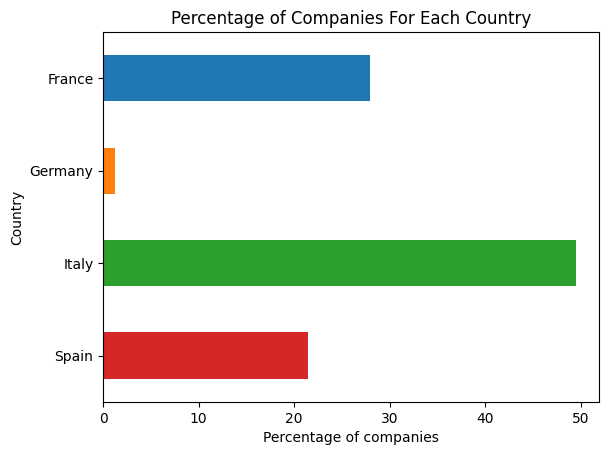

In [63]:
(companies_df.groupby('Country').size() / len(companies_df) * 100).plot(kind='barh', color=list(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])).invert_yaxis()
plt.xlabel('Percentage of companies')
plt.title('Percentage of Companies For Each Country');

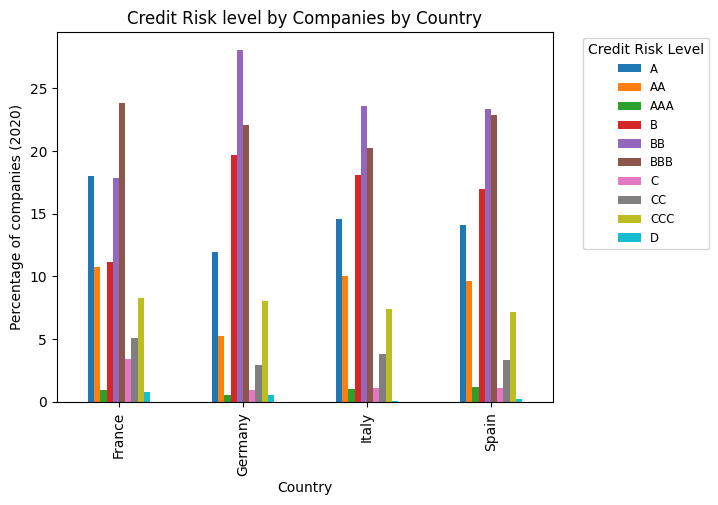

In [64]:
year_widget = widgets.IntSlider(value=2020, min=2015, max=2020, description='Year:', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')

(companies_df.groupby(['Country', 'MScore.'+str(year_widget.value)]).size() / (companies_df.groupby(['Country']).size()) * 100).unstack().plot.bar()
plt.xlabel('Country')
plt.ylabel('Percentage of companies ('+str(year_widget.value)+')')
plt.title('Credit Risk level by Companies by Country')
plt.legend(title='Credit Risk Level', fontsize='small', fancybox=True, bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [65]:
# cast MScore of different years into integer values
for col in [c for c in companies_df.columns if c.startswith('MScore.')]:
    companies_df[str(col)+'.int'] = companies_df[str(col)].apply(lambda x: MScore_to_int(x))

Check whether companies have more high or low credit risk.

In [66]:
low, high = [], []
for year in range(2015, 2021):
    low.append(companies_df['MScore.'+str(year)+'.int'].value_counts()[0])
    high.append(companies_df['MScore.'+str(year)+'.int'].value_counts()[1])
print('Average number of low level credit risk companies:', int(np.mean(low)))
print('Average number of high level credit risk companies:', int(np.mean(high)))

Average number of low level credit risk companies: 107824
Average number of high level credit risk companies: 13184


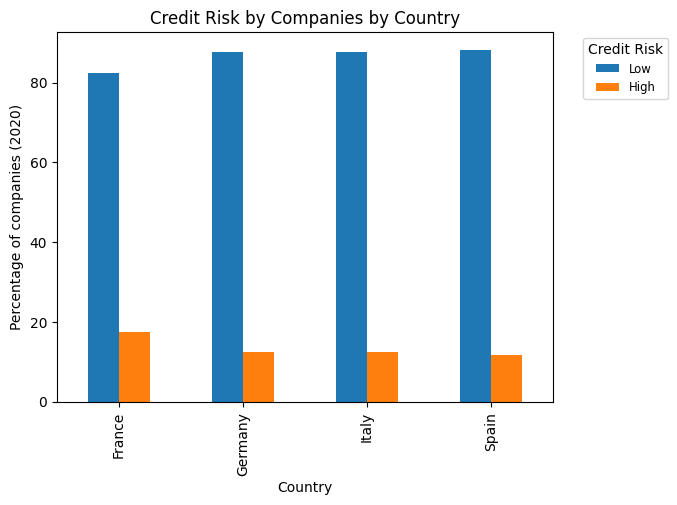

In [67]:
(companies_df.groupby(['Country', 'MScore.'+str(year_widget.value)+'.int']).size() / (companies_df.groupby(['Country']).size()) * 100).unstack().plot.bar()
plt.xlabel('Country')
plt.ylabel('Percentage of companies ('+str(year_widget.value)+')')
plt.title('Credit Risk by Companies by Country')
plt.legend(['Low', 'High'], title='Credit Risk', fontsize='small', fancybox=True, bbox_to_anchor=(1.05, 1.0), loc='upper left');

We can see that France is the country that is going worse

In [68]:
# companies with low and high level credit risk, for each city in a country (in an year)
(companies_df.groupby(['MScore.'+str(year_widget.value)+'.int', 'Country', 'Region']).size() / (companies_df.groupby(['Country','Region']).size()) * 100).unstack()

MScore.2020.int                          0          1
Country Region                                       
France  Ain                      88.418079  11.581921
        Aisne                    82.547170  17.452830
        Allier                   83.941606  16.058394
        Alpes-Maritimes          79.387755  20.612245
        Alpes-de-Haute-Provence  96.624473   3.375527
...                                    ...        ...
Spain   Valencia                 91.955307   8.044693
        Valladolid               90.909091   9.090909
        Vizcaya                  84.916865  15.083135
        Zamora                   95.454545   4.545455
        Zaragoza                 88.707654  11.292346

[584 rows x 2 columns]

### Exploring Countries by different years

Check impact of covid-19 on the credit risk of the companies

In [69]:
for year in range(2015, 2021):
    print(' High credit risk level companies in ' + str(year) + ': ' + str(companies_df['MScore.'+str(year)+'.int'].value_counts()[1]))

 High credit risk level companies in 2015: 14199
 High credit risk level companies in 2016: 12635
 High credit risk level companies in 2017: 11652
 High credit risk level companies in 2018: 11873
 High credit risk level companies in 2019: 12160
 High credit risk level companies in 2020: 16585


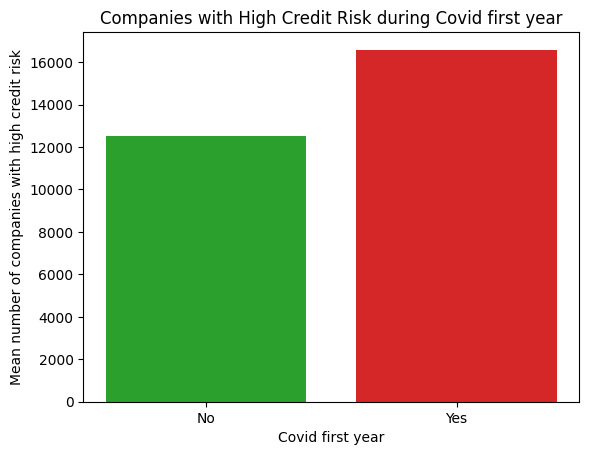

In [70]:
# Check the companies affected by covid
plt.bar([0,1], [np.mean(high[:-1]), high[-1]], color=list(['#2ca02c', '#d62728']))
plt.xlabel('Covid first year')
plt.xticks([0,1], ['No', 'Yes'])
plt.ylabel('Mean number of companies with high credit risk')
plt.title('Companies with High Credit Risk during Covid first year');

In [71]:
print('Percentage increase in high risk level companies in 2020 (with respect to past years): ' + str(round((high[-1] - np.mean(high[:-1])) / np.mean(high[:-1]) * 100, 1)) + '%')

Percentage increase in high risk level companies in 2020 (with respect to past years): 32.6%


We did observed a 32.6% increment in the high risk level in companies in 2020.

### Exploring Companies by general sector

In [72]:
(companies_df.groupby('Sector 2').size() / len(companies_df) * 100).to_frame()

0
Sector 2                                              
Automobiles and Components                    2.735356
Capital Goods                                14.461854
Commercial and professional services          8.953953
Consumer Durables and Apparel                 3.950978
Consumer Services                             2.948565
Diversified Financials                        0.666072
Energy                                        0.075202
Food Beverage and Tobacco                     5.879777
Food and Staples Retailing                    7.297038
Health Care Equipment and Services            2.305633
Household and Personal Products               0.348737
Materials                                     9.881991
Media & Entertainment                         2.398189
Pharmaceuticalcs biotechnology and life sci   0.528891
Real Estate                                   2.004000
Retailing                                    24.923146
Software and Services                         1.832937
Technology Hardware and Equipment             0.866885
Telecommunication Services                    0.244612
Transportation                                6.339250
Utilities                                     1.356935

In [73]:
(companies_df.groupby(['Country', 'Sector 2']).size() / (companies_df.groupby(['Country']).size()) * 100).to_frame()

0
Country Sector 2                                       
France  Automobiles and Components             1.778317
        Capital Goods                         14.395195
        Commercial and professional services  13.433542
        Consumer Durables and Apparel          1.600781
        Consumer Services                      3.373180
...                                                 ...
Spain   Software and Services                  1.664607
        Technology Hardware and Equipment      0.428704
        Telecommunication Services             0.266492
        Transportation                         6.936505
        Utilities                              1.602812

[83 rows x 1 columns]

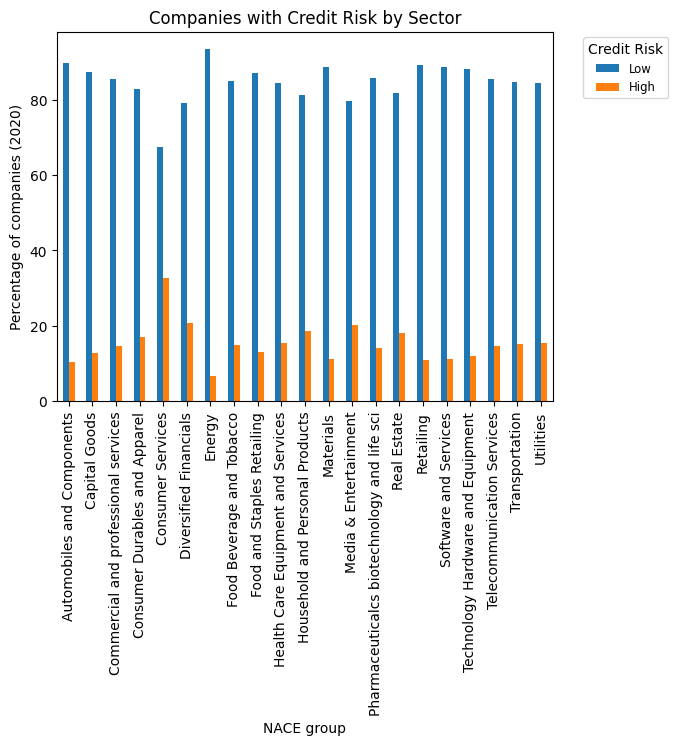

In [74]:
(companies_df.groupby(['MScore.'+str(year_widget.value)+'.int', 'Sector 2']).size() / (companies_df.groupby(['Sector 2']).size()) * 100).unstack('MScore.'+str(year_widget.value)+'.int').plot.bar();
plt.xlabel('NACE group')
plt.ylabel('Percentage of companies ('+str(year_widget.value)+')')
plt.title('Companies with Credit Risk by Sector');
plt.legend(['Low', 'High'], title='Credit Risk', fontsize='small', fancybox=True, bbox_to_anchor=(1.05, 1.0), loc='upper left');

Check whether the creadit risk level remains constnat for subsequent year.

This check is required to understand whether MScore represents a default value or a credit risk level.

In [75]:
year_widget = widgets.IntSlider(value=2019, min=2015, max=2019, description='Year:', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')

test_df = companies_df[companies_df['MScore.'+str(year_widget.value)] == companies_df['MScore.'+str(year_widget.value+1)]][['Company name', 'MScore.'+str(year_widget.value),  'MScore.'+str(year_widget.value+1)]]
n = test_df[test_df['MScore.'+str(year_widget.value)] == 'D'].count()[0]
print(str(n) + ' companies had a D credit risk level in ' + str(year_widget.value) + ' and the consequent year')

153 companies had a D credit risk level in 2019 and the consequent year


## Perform One-Hot Encoding

In [76]:
# Perform one-hot encoding on country
encoder = OneHotEncoder()
encoder.fit(companies_df[['Country']])
encoder_df = pd.DataFrame(encoder.fit_transform(companies_df[['Country']]).toarray())
encoder_df.columns = [i[8:] for i in encoder.get_feature_names_out().tolist()]
print(encoder_df.columns)
companies_df = companies_df.join(encoder_df.iloc[:, -4:].apply(pd.to_numeric, downcast='integer'))
companies_df

Index(['France', 'Germany', 'Italy', 'Spain'], dtype='object')


Company name  Turnover.2020  \
0                                       LENDLEASE S.R.L.          29458   
0                                     TEKNIA MANRESA SL.          18343   
0                                       KAELIS WORLD SL.          10848   
0      RISORSA SOCIALE GERA D'ADDA AZIENDA SPECIALE C...           7273   
0      AALBERTS SURFACE TECHNOLOGIES TEY SOCIEDAD LIM...           5290   
...                                                  ...            ...   
21249                               ASTOR VILLAGE S.R.L.           3161   
21250                                ODONE & SLOA S.R.L.           3161   
21251                     GARRIDO MURO SOCIEDAD LIMITADA           3161   
21252                       CENTRO INGROSSO JOLLY S.R.L.           3161   
21253                                 SALONES COMATEL SL           3161   

       Turnover.2019  Turnover.2018  Turnover.2017  Turnover.2016  \
0              16716           9612           8097         7941.0   
0              24203          24581          26460        24287.0   
0              13068          10371          10083         9327.0   
0               6693           5403           4151         3551.0   
0               6414           7715           7805         8802.0   
...              ...            ...            ...            ...   
21249           4635           4742           4499         4277.0   
21250           2562           2559           2334         3692.0   
21251           3146           2989           3101         2746.0   
21252           2519           2290           2244         1761.0   
21253           4514           4435           4231         3908.0   

       Turnover.2015  EBIT.2020  EBIT.2019  EBIT.2018  ...  MScore.2020.int  \
0             5600.0    -1556.0    -4540.0      623.0  ...                1   
0            23002.0     1872.0     2638.0     2563.0  ...                0   
0             8678.0     -184.0      571.0      467.0  ...                1   
0             2936.0       29.0       30.0       52.0  ...                0   
0             9238.0    -1096.0    -1023.0     -178.0  ...                1   
...              ...        ...        ...        ...  ...              ...   
21249         3650.0      985.0     1818.0     1790.0  ...                0   
21250         2537.0       60.0      101.0       27.0  ...                0   
21251         3154.0      260.0       13.0       48.0  ...                0   
21252         1821.0       74.0       48.0       60.0  ...                0   
21253         2051.0      194.0      733.0      830.0  ...                0   

       MScore.2019.int  MScore.2018.int  MScore.2017.int  MScore.2016.int  \
0                    1                1                1                0   
0                    0                0                0                0   
0                    0                0                0                0   
0                    0                0                0                0   
0                    1                1                1                1   
...                ...              ...              ...              ...   
21249                0                0                0                0   
21250                1                1                1                1   
21251                0                0                0                0   
21252                0                0                0                0   
21253                0                0                0                0   

       MScore.2015.int  France  Germany  Italy Spain  
0                    1       0        0      1     0  
0                    0       0        0      1     0  
0                    0       0        0      1     0  
0                    0       0        0      1     0  
0                    0       0        0      1     0  
...                ...     ...      ...    ...   ...  
21249                0       0        0      0     1  


In [77]:
# Perform one-hot encoding on general sector
encoder.fit(companies_df[['Sector 2']])
encoder_df = pd.DataFrame(encoder.fit_transform(companies_df[['Sector 2']]).toarray())
encoder_df.columns = [i[9:] for i in encoder.get_feature_names_out().tolist()]
print(encoder_df.columns)
companies_df = companies_df.join(encoder_df.iloc[:, -21:].apply(pd.to_numeric, downcast='integer'))
companies_df

Index(['Automobiles and Components', 'Capital Goods',
       'Commercial and professional services', 'Consumer Durables and Apparel',
       'Consumer Services', 'Diversified Financials', 'Energy',
       'Food Beverage and Tobacco', 'Food and Staples Retailing',
       'Health Care Equipment and Services', 'Household and Personal Products',
       'Materials', 'Media & Entertainment',
       'Pharmaceuticalcs biotechnology and life sci', 'Real Estate',
       'Retailing', 'Software and Services',
       'Technology Hardware and Equipment', 'Telecommunication Services',
       'Transportation', 'Utilities'],
      dtype='object')


Company name  Turnover.2020  \
0                                       LENDLEASE S.R.L.          29458   
0                                     TEKNIA MANRESA SL.          18343   
0                                       KAELIS WORLD SL.          10848   
0      RISORSA SOCIALE GERA D'ADDA AZIENDA SPECIALE C...           7273   
0      AALBERTS SURFACE TECHNOLOGIES TEY SOCIEDAD LIM...           5290   
...                                                  ...            ...   
21249                               ASTOR VILLAGE S.R.L.           3161   
21250                                ODONE & SLOA S.R.L.           3161   
21251                     GARRIDO MURO SOCIEDAD LIMITADA           3161   
21252                       CENTRO INGROSSO JOLLY S.R.L.           3161   
21253                                 SALONES COMATEL SL           3161   

       Turnover.2019  Turnover.2018  Turnover.2017  Turnover.2016  \
0              16716           9612           8097         7941.0   
0              24203          24581          26460        24287.0   
0              13068          10371          10083         9327.0   
0               6693           5403           4151         3551.0   
0               6414           7715           7805         8802.0   
...              ...            ...            ...            ...   
21249           4635           4742           4499         4277.0   
21250           2562           2559           2334         3692.0   
21251           3146           2989           3101         2746.0   
21252           2519           2290           2244         1761.0   
21253           4514           4435           4231         3908.0   

       Turnover.2015  EBIT.2020  EBIT.2019  EBIT.2018  ...  Materials  \
0             5600.0    -1556.0    -4540.0      623.0  ...          0   
0            23002.0     1872.0     2638.0     2563.0  ...          0   
0             8678.0     -184.0      571.0      467.0  ...          0   
0             2936.0       29.0       30.0       52.0  ...          0   
0             9238.0    -1096.0    -1023.0     -178.0  ...          0   
...              ...        ...        ...        ...  ...        ...   
21249         3650.0      985.0     1818.0     1790.0  ...          0   
21250         2537.0       60.0      101.0       27.0  ...          0   
21251         3154.0      260.0       13.0       48.0  ...          0   
21252         1821.0       74.0       48.0       60.0  ...          0   
21253         2051.0      194.0      733.0      830.0  ...          1   

       Media & Entertainment  Pharmaceuticalcs biotechnology and life sci  \
0                          0                                            0   
0                          0                                            0   
0                          0                                            0   
0                          0                                            0   
0                          0                                            0   
...                      ...                                          ...   
21249                      0                                            0   
21250                      0                                            0   
21251                      0                                            0   
21252                      0                                            0   
21253                      0                                            0   

       Real Estate  Retailing  Software and Services  \
0                0          0                      0   
0                0          0                      0   
0                0          0                      0   
0                0          0                      0   
0                0          0                      0   
...            ...        ...                    ...   
21249            0          0                      0   
21250            0          1                      0   
21251   

## Correlation Analysis

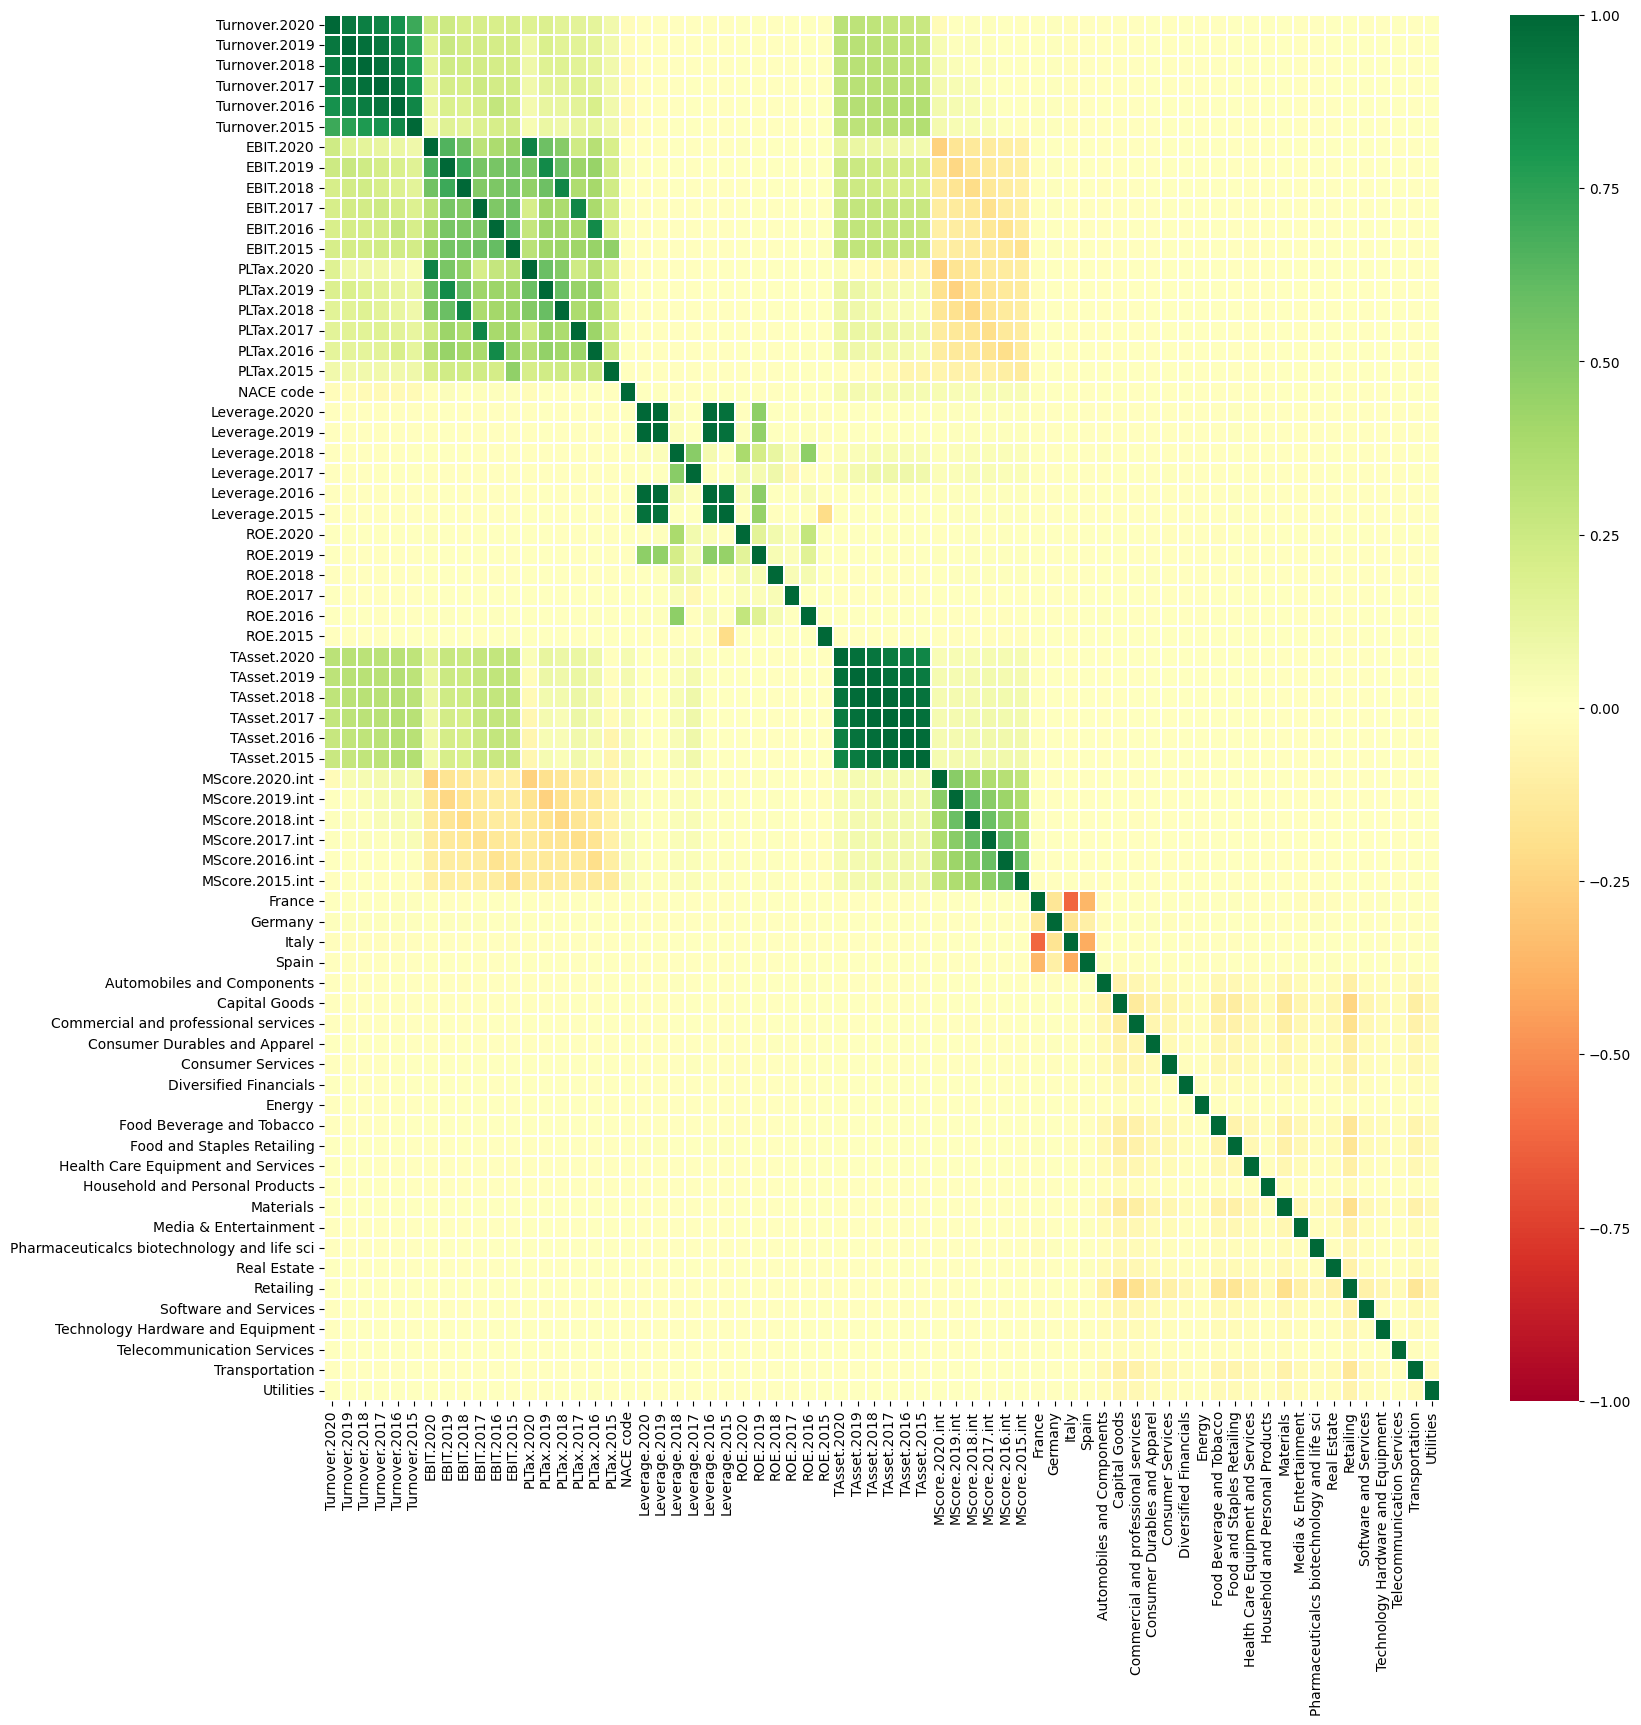

In [78]:
# Pearson Correlation
plt.figure(figsize=(18, 18))
sns.heatmap(companies_df.corr(), cmap='RdYlGn', linewidths = 0.1, vmin=-1, vmax=1)

<Axes: >

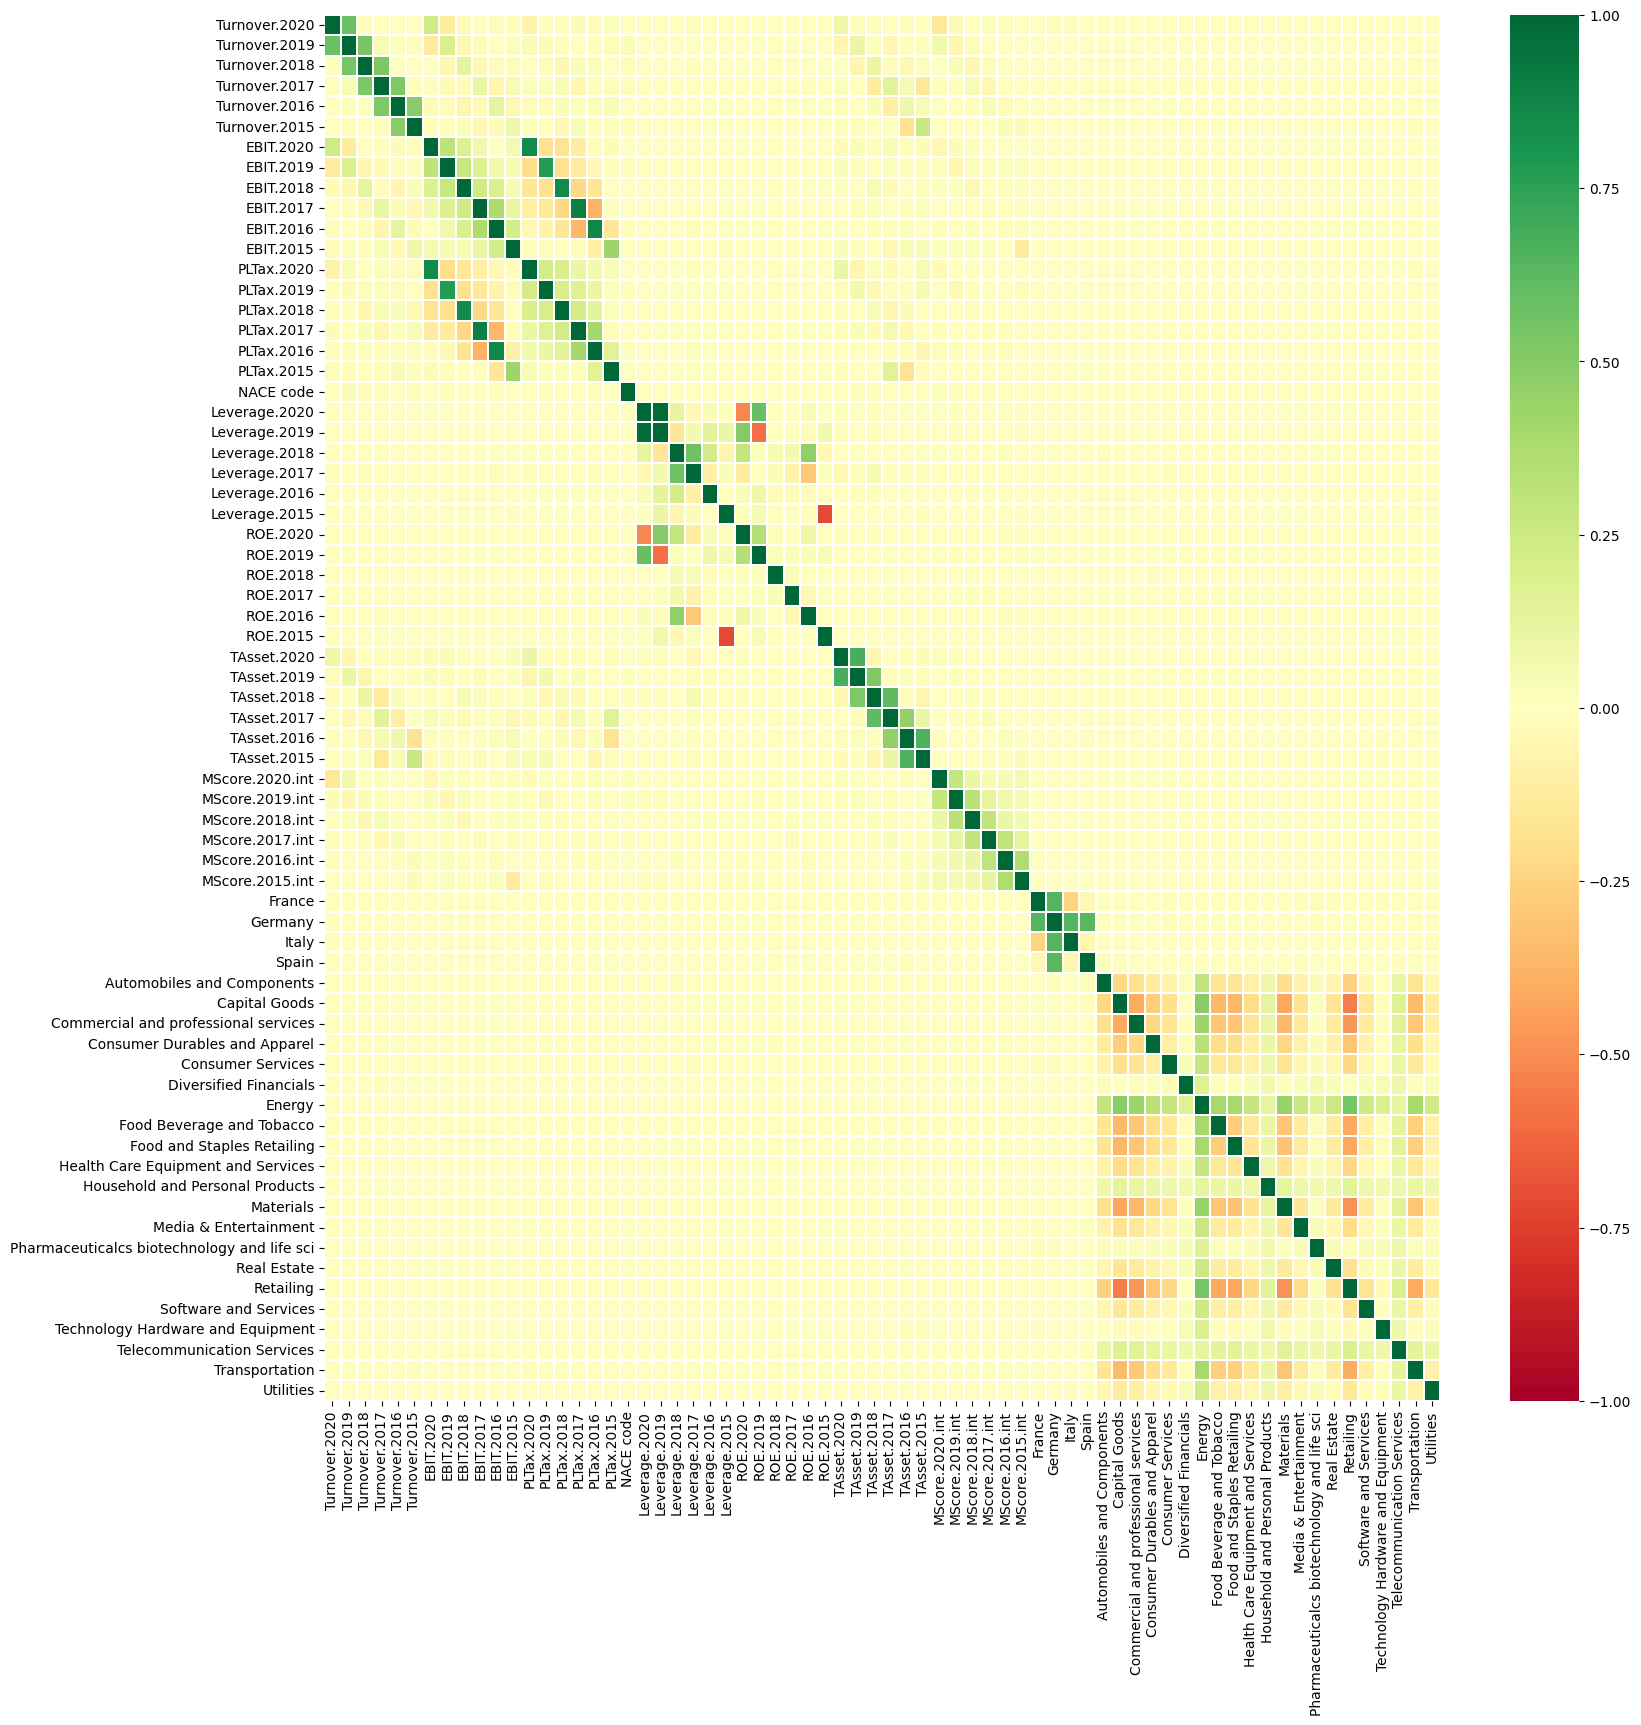

In [79]:
# Partial correlations
plt.figure(figsize=(18, 18))
sns.heatmap(pg.pcorr(companies_df), cmap='RdYlGn', linewidths = 0.1, vmin=-1, vmax=1)

From the correlation plots, we can see that out target variable MScore is positively correlated with previous year MScores. This suggests that if a company has high credit risk level in a year it is highly likely that the same will happen in the following year.

Additionally, we observed that if Turnover and EBIT features are in the same year then the negative values of those will cause an increase in the credit risk level.

## Machine Learning Model

### Handling Imbalanced Data

Utilizing undersampling to balance the data. Undersampling involves reducing the number of instances in the overrepresented class (in this case, the low-risk class) to match the number of instances in the underrepresented class (the high-risk class).

In [82]:
high_risk_df = companies_df[companies_df['MScore.2019.int'] == 1]
low_risk_df = companies_df[companies_df['MScore.2019.int'] == 0].sample(n=len(high_risk_df), random_state=0)

restricted_df = pd.concat([low_risk_df, high_risk_df])
restricted_df.sort_index(inplace=True)

For prediction, we are using past year data to predict next year credit risk level

In [83]:
year_widget = widgets.IntSlider(value=2018, min=2015, max=2019, description='Year:', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
year_widget

IntSlider(value=2018, description='Year:', max=2019, min=2015)

### Logistic Regression

In [93]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int']]], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

MScore.2015.int  MScore.2016.int  MScore.2017.int  MScore.2018.int
0                    1                0                1                1
0                    0                1                1                1
0                    0                0                0                0
1                    0                0                0                0
2                    0                0                0                0
...                ...              ...              ...              ...
21240                1                1                0                0
21241                1                1                1                1
21244                0                0                0                0
21249                0                0                0                0
21250                1                1                1                1

[24320 rows x 4 columns]

In [94]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 80.8%
 - Test accuracy: 81.8%

Test               precision    recall  f1-score   support

           0       0.76      0.93      0.84      2432
           1       0.91      0.70      0.79      2432

    accuracy                           0.82      4864
   macro avg       0.84      0.82      0.82      4864
weighted avg       0.84      0.82      0.82      4864



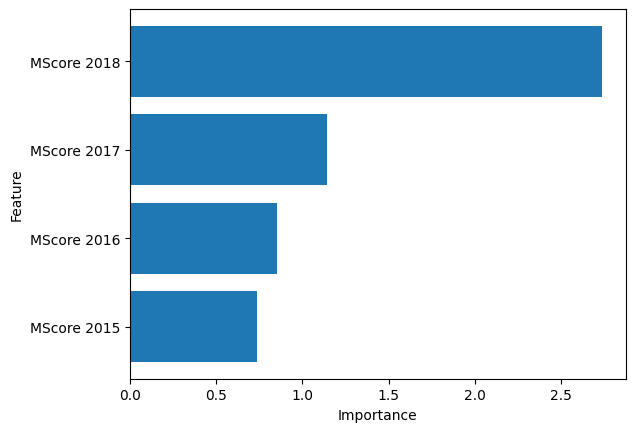

In [96]:
importance = lr.coef_[0]
importance=np.sort(importance)

sns.set_style()
plt.barh([i for i in range (len(importance))], importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
list_ticks, features_names = [], []
for i in range(0, year_widget.value - 2014):
    list_ticks.append(i)
    features_names.append('MScore '+str(2015 + i))
plt.yticks(list_ticks, features_names)
plt.show()

### Decision Tree

In [97]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, np.ravel(y_train))
print_performances('Decision Tree Classifier', dtc, X_train, y_train, X_test, y_test)

Decision Tree Classifier
 - Train accuracy: 81.5%
 - Test accuracy: 82.8%

Test               precision    recall  f1-score   support

           0       0.78      0.90      0.84      2432
           1       0.89      0.75      0.81      2432

    accuracy                           0.83      4864
   macro avg       0.84      0.83      0.83      4864
weighted avg       0.84      0.83      0.83      4864



### Random Forest

In [99]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, np.ravel(y_train))
print_performances('Random Forest Classifier', rfc, X_train, y_train, X_test, y_test)

Random Forest Classifier
 - Train accuracy: 81.5%
 - Test accuracy: 82.8%

Test               precision    recall  f1-score   support

           0       0.78      0.90      0.84      2432
           1       0.89      0.75      0.81      2432

    accuracy                           0.83      4864
   macro avg       0.84      0.83      0.83      4864
weighted avg       0.84      0.83      0.83      4864



### SVM

In [100]:
svc = SVC(kernel='poly', random_state=0)
svc.fit(X_train, np.ravel(y_train))
print_performances('Support Vector Classifier', svc, X_train, y_train, X_test, y_test)

Support Vector Classifier
 - Train accuracy: 81.5%
 - Test accuracy: 82.8%

Test               precision    recall  f1-score   support

           0       0.78      0.90      0.84      2432
           1       0.89      0.75      0.81      2432

    accuracy                           0.83      4864
   macro avg       0.84      0.83      0.83      4864
weighted avg       0.84      0.83      0.83      4864



### Model Comparison

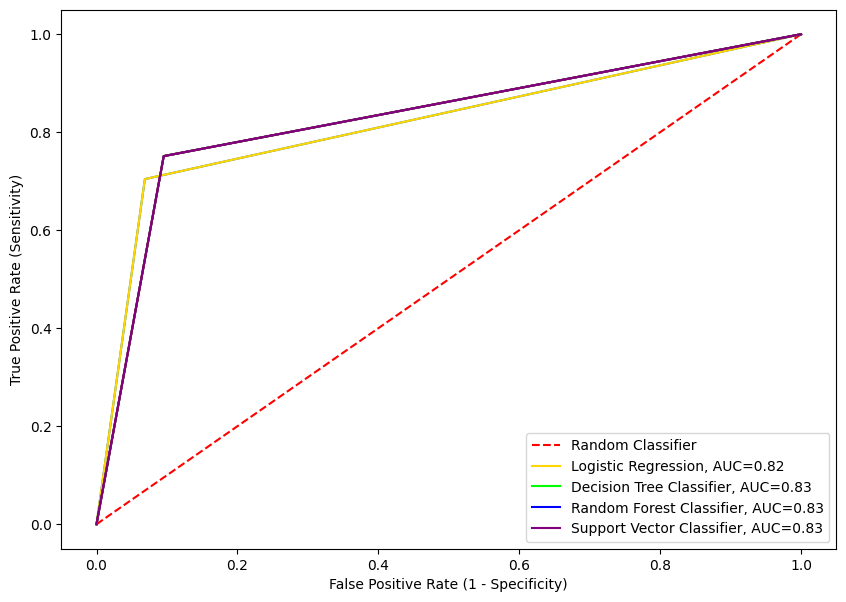

In [101]:
plt.figure(0, figsize=(10, 7)).clf()

colors = ['#ff0000', '#ffd700', '#00ff00', '#0000ff', '#800080']

# Random Classifier
random_fpr, random_tpr, _ = metrics.roc_curve(y_test, [0 for _ in range(len(y_test))])
plt.plot(random_fpr, random_tpr, linestyle='--', color=colors[0], label='Random Classifier')

# Logistic Regression
y_pred = lr.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[1], label='Logistic Regression, AUC='+str(auc))

# Decision Tree Classifier
y_pred = dtc.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[2], label='Decision Tree Classifier, AUC='+str(auc))

# Random Forest Classifier
y_pred = rfc.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[3], label='Random Forest Classifier, AUC='+str(auc))

# Support Vector Classifier
y_pred = svc.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[4], label='Support Vector Classifier, AUC='+str(auc))

plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend()
plt.show();

We can see that Decision Tree, Random Forest and SVM classifer are the best models.